In [395]:
tex_fonts = {
    # Use LaTeX to write all text
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 16,
    "font.size": 16,
    "axes.titlesize" : 16,
    'text.latex.preamble': r'\usepackage{amsfonts, amsmath,amssymb, mathrsfs}',
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 14,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14, 
    'figure.autolayout': True
    
}

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from scipy.ndimage import convolve
from scipy.optimize import minimize
import pandas as pd
from matplotlib.gridspec import GridSpec
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")
plt.rcParams.update(tex_fonts)

In [396]:
#### WESTERN EUROPE ####
df_list = []
df = pd.read_csv('Data FAO/FAOSTAT_AREA.csv')
df_list.append(df)
df = pd.read_csv('Data FAO/FAOSTAT_YIELD.csv')
df_list.append(df)
df = pd.read_csv('Data FAO/FAOSTAT_FERTILIZER.csv')
df_list.append(df)
df = pd.read_csv('Data FAO/FAOSTAT_PESTICIDE.csv')
df_list.append(df)
df_Price = pd.read_csv('Data FAO/commodity-price-index-cereal-crops-and-petroleum.csv')
df_Price = df_Price.rename(columns={"Wheat": "Value"})
condition = df_Price['Year'] >= 1961
df_Price = df_Price[condition]
df_list.append(df_Price)

# Model Parameters

In [397]:
# Model dimension
num_steps = 100  # Number of simulation time steps
size = 5
frac_conventional = 1
frac_organic = 0.0

# Production Parameters
ymax = 9  # Maximum achievable yield
Nr = 60  # Nutrient response parameter
p0 = 500  # Operational cost
p1 = 1000  # Non operational cost
p_F = 0.8  # Price of fertilizer
p_L = 7000
Nutrient_release_SOM = 10

# Farmers Behaviour
omega = 0.2
competitiveness_param = 0.9  # Exponent in households' utility function
beta = 5  # Land redistribution parameter
theta = 0  # Threshold wealth for farmer bankruptcy
delta = 0.1 # R&D investment fraction
demand_growth = 0.025  # Demand growth rate

# Policy
natural_conservation = 100

# Model Functions

In [398]:
def generate_colormap_matrix(colormap_name, size):
    cmap = plt.get_cmap(colormap_name)
    norm = plt.Normalize(0, size - 1)

    colors = cmap(norm(range(size)))
    colors = np.reshape(colors, (size, 4))

    return colors

def initialize_land_types(size, frac_conventional, frac_organic):
    total_cells = size * size
    if frac_conventional < 1:
        num_conventional = int(total_cells * frac_conventional)
    else:
        num_conventional = frac_conventional

    # Identify the center of the matrix
    center_row = size // 2
    center_col = size // 2

    # Create submatrix with 0.8 density of 'C'
    submatrix_size = int(np.sqrt(num_conventional / 0.5))
    land_types_flat = (['C'] * num_conventional + ['N'] * (submatrix_size**2 - num_conventional))
    np.random.shuffle(land_types_flat)
    land_type = np.array(land_types_flat).reshape((submatrix_size, submatrix_size))
    submatrix = land_type

    # Place the submatrix in the center of the larger matrix
    start_row = center_row - submatrix_size // 2
    start_col = center_col - submatrix_size // 2

    # Fill the remaining cells with 'N'
    surrounding_natural = np.full((size, size), 'N')
    surrounding_natural[start_row:start_row+submatrix_size, start_col:start_col+submatrix_size] = submatrix
    
    return surrounding_natural

def initialize_soil_health_and_biodiversity(size, land, initial_soil = 0.1, initial_bio = 0.3):
    soil_health = np.zeros((size, size))
    soil_health[land != 'N'] = 1 - initial_soil * np.random.rand(np.sum(land != 'N'))
    soil_health[land == 'N'] = 1 - 0.001 * np.random.rand(np.sum(land == 'N'))
    
    biodiversity = np.zeros((size, size))
    biodiversity[land == 'N'] = 1 - 0.001 * np.random.rand(np.sum(land == 'N'))
    biodiversity[land != 'N'] = 1 - initial_bio * np.random.rand(np.sum(land != 'N'))

    return soil_health, biodiversity

def update_soil_health(soil_health, land_type, SOM_rate_organic = 0.5, SOM_rate_conventional = -0.05, SOM_rate_natural = 0.01):

    delta_h = np.where(land_type == 'O', SOM_rate_organic, SOM_rate_conventional)
    delta_h[land_type == 'N'] = SOM_rate_natural  
    soil_health += delta_h * soil_health * (1 - soil_health)

    return soil_health

def update_biodiversity(biodiversity, land_type, bio_rate_organic = 0.1, bio_rate_natural = 0.05, bio_rate_conventional = -0.1):
    
    delta_b = np.where(land_type == 'O', bio_rate_organic, bio_rate_conventional)
    delta_b[land_type == 'N'] = bio_rate_natural

    kernel = np.array([[1, 1, 1],
                       [1, 1, 1],
                       [1, 1, 1]]) / 9.0
    delta_b = convolve(delta_b, kernel, mode='wrap')

    

    biodiversity += delta_b * biodiversity * (1 - biodiversity)

    return biodiversity
    
def productionfunction(F, S, M, y_max = ymax, N_req = Nr, Nutrient_release_SOM = Nutrient_release_SOM):
    return y_max * (1 - np.exp(-1/N_req * (Nutrient_release_SOM * S + M * F))) * (1 + np.random.normal(0, 0.05, F.shape)) 

def utility_function(F, S, M, price, previous_prod, markup, inertia_rate, y_max = ymax, N_req = Nr, Nutrient_release_SOM = Nutrient_release_SOM):

    expected_production = np.sum(y_max * (1 - np.exp(-1/N_req * (Nutrient_release_SOM * S + M * F))))
    expected_cost = np.sum(p_F * F + p0) + p1
    expected_revenues = price/(1 + markup) * expected_production 
    Profit_try = expected_revenues - expected_cost
    Risk_try = (expected_production - previous_prod)**2
    Utility_try = -( Profit_try - inertia_rate * price/(1 + markup) * Risk_try )

    # print(Profit_try, Risk_try)

    return Utility_try

def vectorize_maximization(x, F, S, M, price, previous_prod, markup, inertia_rate):
    x = np.split(x.reshape(size, 2 * size), 2, axis=1)
    L = x[0].astype(bool)
    O = x[1].astype(bool)

    results = minimize(utility_function, F[O], method='Nelder-Mead', \
                          args=(S[O], M[L], price[L], previous_prod[L], markup[L], inertia_rate[L]), tol=0.1, bounds=[(0, np.inf)] * np.sum(O))

    F_opt = np.zeros((size, size)) 
    F_opt[O] = results.x   

    return F_opt
    
def create_ownership_matrix(farmsteads, farms_ownership):
    farms_unique, farms_counts = np.unique(farms_ownership, return_counts=True)
    farms_unique = farms_unique[:-1]
    farms_counts = farms_counts[:-1]
    num_unique_values = len(farms_unique)  # Number of unique values in A
    masks = (farms_ownership[:, :, np.newaxis] == farms_unique)
    ownership_i = np.zeros((size, size,  num_unique_values), dtype=int)
    ownership_i[masks] = 1

    masks = (farmsteads[:, :, np.newaxis] == farms_unique)
    farmsteads_i = np.zeros((size, size,  num_unique_values), dtype=int)
    farmsteads_i[masks] = 1

    return np.transpose(farmsteads_i, (2,0,1)), np.transpose(ownership_i, (2,0,1))

def compute_demand(y, p, demand, beta, delta=0.1):
    # Calculate the number of True values in each row
    num_true_values = np.floor(y/delta).astype(int)

    # Create the matrix with the specified number of True values in each row
    final_matrix = np.arange(np.max(num_true_values)) < num_true_values[:, None]

    # Calculate probabilities for each element in the matrix
    exponent_term = 1/num_true_values * p**(1/(beta-1)) 
    probabilities = exponent_term[:, np.newaxis] * final_matrix
    probabilities /= np.sum(probabilities)
    
    unit_to_be_bought = np.floor(demand / delta).astype(int)
    unit_available = np.sum(probabilities>0)

    # Randomly select products based on probabilities
    if unit_available > unit_to_be_bought:
        selected_products = np.random.choice(np.arange(probabilities.size),
                                            size=unit_to_be_bought,
                                            p=probabilities.ravel(),
                                            replace=False)
        
        # Create a boolean matrix based on the selected products
        matrix = np.zeros(final_matrix.shape, dtype=bool)
        matrix[np.unravel_index(selected_products, final_matrix.shape)] = True

        # Calculate demand for each product
        return delta * np.sum(matrix, axis=1)

    else:
        return y


# Model Initialization

In [399]:
#### GENERAL ####
demand = np.zeros(num_steps)
farmsteads_number = np.zeros(num_steps, dtype=int)

#### FARMSTEADS ####
Y = np.zeros((num_steps, size, size)) 
MP = np.zeros((num_steps, size, size)) 
inertia_rate = np.zeros((num_steps, size, size)) 
markup = np.zeros((num_steps, size, size)) 
price = np.zeros((num_steps, size, size)) 
profit = np.zeros((num_steps, size, size)) 
revenues = np.zeros((num_steps, size, size)) 
costs = np.zeros((num_steps, size, size)) 
wealth = np.zeros((num_steps, size, size)) 
fraction_sold = np.zeros((num_steps, size, size)) 
farmer_demand = np.zeros((num_steps, size, size)) 
research_investment = np.zeros((num_steps, size, size)) 
demand_per_farmer = np.zeros((num_steps, size, size)) 
quitting = np.zeros((num_steps, size, size)) 

#### SPATIAL VARIABLES
land_type = np.zeros((num_steps, size, size), dtype=str)
farms_ownership = np.nan * np.zeros((num_steps, size, size)) 
farmsteads = np.nan * np.zeros((num_steps, size, size), dtype=int)
active_farms = np.zeros((num_steps, size, size), dtype = bool) 
F = np.zeros((num_steps, size, size))
S = np.zeros((num_steps, size, size))
B = np.zeros((num_steps, size, size))
y = np.zeros((num_steps, size, size))
kernel = np.array([[1, 1, 1],
                    [1, 0, 1],
                    [1, 1, 1]]) 

#### Initialize Landscape 
land_type[0] = initialize_land_types(size, frac_conventional, frac_organic)
S[0], B[0] = initialize_soil_health_and_biodiversity(size, land_type[0])
farmsteads[0, land_type[0] != 'N'] = np.arange(np.sum(land_type[0] != 'N')) # np.array([0,1, np.nan])#
farms_ownership[0] = farmsteads[0] #np.array([0,1, 1])#
active_farms[0] = ~np.isnan(farmsteads[0])
farmsteads_i, ownership_i = create_ownership_matrix(farmsteads[0], farms_ownership[0])

for i in range(np.sum(active_farms[0])):

    O = ownership_i[i,:,:].astype(bool)
    L = farmsteads_i[i,:,:].astype(bool)
    F[0, O] = np.random.uniform(low = 0, high = 60, size = np.sum(O))
    MP[0, L] = np.random.uniform(low= 0.4, high = 0.5)
    y[0, O] = productionfunction(F[0, O], S[0, O], MP[0, L])
    Y[0, L] = np.sum(y[0, O])
    markup[0, L] = 0.2
    costs[0, L] = np.sum(F[0, O] * p_F + p0) + p1
    price[0, L] = (1 + markup[0, L]) * costs[0, L]/Y[0, L]


inertia_rate[0, active_farms[0]] = np.random.uniform(low= 1.5, high = 2.5, size=np.sum(active_farms[0]))
demand[0] = np.sum(Y[0, active_farms[0]])
demand_per_farmer[0, active_farms[0]] = compute_demand(Y[0, active_farms[0]], price[0, active_farms[0]], demand[0], competitiveness_param) 
fraction_sold[0, active_farms[0]] = 1/Y[0, active_farms[0]] * np.minimum(demand_per_farmer[0, active_farms[0]], Y[0, active_farms[0]])
revenues[0, active_farms[0]] = price[0, active_farms[0]] * fraction_sold[0, active_farms[0]] * Y[0, active_farms[0]]
profit[0, active_farms[0]] =  revenues[0, active_farms[0]] - costs[0, active_farms[0]]
wealth[0, active_farms[0]] = 10000
quitting[0, active_farms[0]] = profit[0, active_farms[0]]
quitting[0, np.invert(active_farms[0])] = theta

In [400]:
(MP[0,active_farms[0]] * F[0,active_farms[0]] + Nutrient_release_SOM * S[0,active_farms[0]]).mean()

12.945073882262351

In [401]:
Y[0, active_farms[0]].mean()

1.738947434234795

In [402]:
demand[0]

1.738947434234795

# Model Dynamics

In [403]:
for t in np.arange(1, num_steps):

    farms_ownership[t] = farms_ownership[t-1]
    farmsteads[t] = farmsteads[t-1]
    land_type[t] = land_type[t-1]
    active_farms[t] = quitting[t-1] > theta
    
    if np.any(quitting[t-1, active_farms[t-1]] < theta):
        # Remove farmers
        farms_ownership[t, np.isin(farms_ownership[t], farmsteads[t, quitting[t-1] < theta])] = np.nan
        farmsteads[t, quitting[t-1] < theta] = np.nan
        land_type[t, quitting[t-1] < theta] = 'N'
        
        # Select new plots
        land_available_idx = np.where(land_type[t] == 'N')
        prob = np.exp(-natural_conservation*(B[t-1, land_type[t] == 'N'] - B[t-1, land_type[t] == 'N'].min())/B[t-1, land_type[t] == 'N'].max() ) / np.sum(np.exp(-natural_conservation*(B[t-1, land_type[t] == 'N'] - B[t-1, land_type[t] == 'N'].min())/B[t-1, land_type[t] == 'N'].max() ))
        selected_idx = np.random.choice(range(len(land_available_idx[0])), np.sum(quitting[t-1, active_farms[t-1]] < theta), replace=False, p=prob)

        for i in range(len(selected_idx)):
            new_land_plot = np.zeros((size,size), dtype=bool)
            new_land_plot[land_available_idx[0][selected_idx[i]], land_available_idx[1][selected_idx[i]]] = True
            possible_farmstads = convolve(new_land_plot, kernel, mode='wrap') * active_farms[t] * (wealth[t-1] >= p_L) 
            if np.any(possible_farmstads):

                prob = np.exp(beta * (wealth[t-1, possible_farmstads]- wealth[t-1, possible_farmstads].min()) / wealth[t-1, possible_farmstads].max()) / np.sum(np.exp(beta * (wealth[t-1, possible_farmstads] - wealth[t-1, possible_farmstads].min()) / wealth[t-1, possible_farmstads].max()))
                auction_winner_idx = np.random.choice(range(len(farmsteads[t, possible_farmstads])), p=prob)
                farms_ownership[t, new_land_plot] = farmsteads[t, possible_farmstads][auction_winner_idx]
                wealth[t, possible_farmstads][auction_winner_idx] -= p_L
                land_type[t, new_land_plot] = 'C'

            else:
                print('new')
                farmsteads[t, new_land_plot] = farmsteads[t, active_farms[t]].max() + 1
                farms_ownership[t, new_land_plot] = farms_ownership[t, active_farms[t]].max() + 1
                wealth[t,new_land_plot] = 10000
                MP[t-1, new_land_plot] = np.mean(MP[t-1, active_farms[t-1]])
                F[t-1, new_land_plot] = np.mean(F[t-1, active_farms[t-1]])
                y[t-1, new_land_plot] = productionfunction(F[t-1,new_land_plot], S[t-1, new_land_plot], MP[t-1, new_land_plot])#np.mean(y[t-1, np.isin(farms_ownership[t], farmsteads[t, quitting[t-1] < theta])])
                Y[t-1, new_land_plot] = np.sum(y[t-1, new_land_plot])
                markup[t-1, new_land_plot] = 0.2
                costs[t-1, new_land_plot] =  np.sum(F[t-1, new_land_plot] * p_F + p0) + p1
                price[t-1, new_land_plot] = (1 + markup[t-1, new_land_plot]) * costs[t-1, new_land_plot] / Y[t-1, new_land_plot]
                fraction_sold[t-1, new_land_plot] = 1 # np.mean(fraction_sold[t-1, np.isin(farms_ownership[t], farmsteads[t, quitting[t-1] < theta])])
                inertia_rate[t-1, new_land_plot] = 1
                quitting[t-1,new_land_plot] = np.mean(profit[t-1, active_farms[t-1]])
                land_type[t, new_land_plot] = 'C'
                active_farms[t, new_land_plot] = True

    farmsteads_i, ownership_i = create_ownership_matrix(farmsteads[t], farms_ownership[t])

    combined_array = np.concatenate((farmsteads_i, ownership_i), axis=2)
    combined_array = combined_array.reshape(combined_array.shape[0], -1)
    F[t] = np.sum(np.apply_along_axis(vectorize_maximization, axis=1, arr=combined_array, \
                                      F=F[t-1], S=S[t-1],  M=MP[t-1], price=price[t-1], previous_prod = fraction_sold[t-1] * Y[t-1], markup=markup[t-1], inertia_rate =inertia_rate[t-1]),\
                                        axis=0)

    y[t] = productionfunction(F[t], S[t-1], MP[t-1])
    Y[t] = np.tensordot(np.sum(ownership_i * y[t], axis=(1,2)), farmsteads_i, axes=1)
    costs[t] = np.tensordot(np.sum(ownership_i * (F[t] * p_F + p0), axis=(1,2)), farmsteads_i, axes=1) + np.sum(p1 * farmsteads_i, axis=0)
    markup[t] = markup[t-1]
    price[t] = (1 + markup[t]) * costs[t]/Y[t]

    demand[t] = demand[t-1] * (  1 + (t <= 30) * demand_growth)
    demand_per_farmer[t, active_farms[t]] = compute_demand(Y[t, active_farms[t]], price[t, active_farms[t]], demand[t], competitiveness_param) 
    fraction_sold[t, active_farms[t]] = 1/Y[t, active_farms[t]] * np.minimum(demand_per_farmer[t, active_farms[t]], Y[t, active_farms[t]])
    revenues[t, active_farms[t]] = price[t, active_farms[t]] * fraction_sold[t, active_farms[t]] * Y[t, active_farms[t]]
    profit[t, active_farms[t]] =  revenues[t, active_farms[t]] - costs[t, active_farms[t]]
    wealth[t, active_farms[t]] = wealth[t-1, active_farms[t]] + profit[t, active_farms[t]]

    inertia_rate[t, active_farms[t]] = inertia_rate[t-1, active_farms[t]] * (1 + np.where(fraction_sold[t, active_farms[t]] < 1, omega, -omega) * np.random.rand(np.sum(active_farms[t])))

    # Research and innovation investment
    research_investment[t, active_farms[t]] = delta * profit[t, active_farms[t]] # research_investment[t-1, active_farms[t]] + 
    farms_innovating = np.random.rand(np.sum(active_farms[t])) < 1 - np.exp(- 1/100 * research_investment[t, active_farms[t]])
    advancement = 0.15 * np.random.rand(np.sum(active_farms[t])) * farms_innovating
    MP[t, active_farms[t]] = MP[t-1, active_farms[t]] + advancement * MP[t-1, active_farms[t]]  * (1 - MP[t-1, active_farms[t]])
    wealth[t, active_farms[t]] = wealth[t, active_farms[t]] - delta * profit[t, active_farms[t]]

    # Quitting Farming
    quitting[t, active_farms[t]] = 0.6 * quitting[t-1, active_farms[t]] + 0.4 * profit[t, active_farms[t]]     
    quitting[t, np.invert(active_farms[t])] = theta

    # Update Soil and Bio
    S[t] = update_soil_health(S[t-1], land_type[t])
    B[t] = update_biodiversity(B[t-1], land_type[t])

    if np.any(np.isnan(Y[t, active_farms[t]])):
        raise
    


# Plots

## All farmers

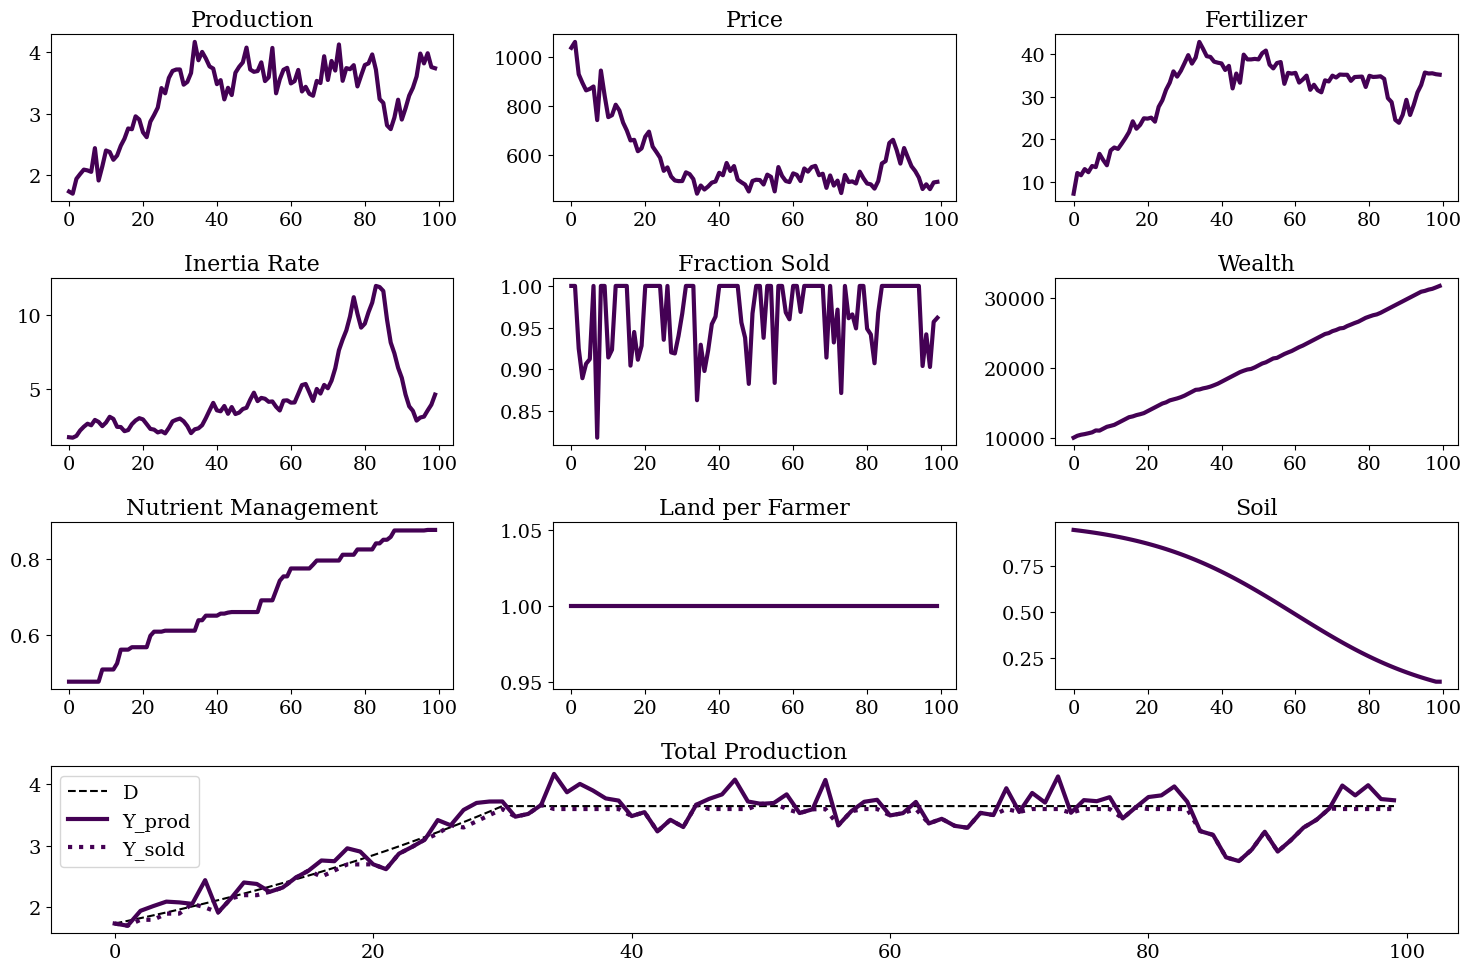

In [404]:

fig = plt.figure(figsize=(15,10))
gs = GridSpec(nrows=4, ncols=3)

c_matrix = generate_colormap_matrix('viridis', farmsteads[active_farms].max().astype(int)+1)

# Plotting demand and production
ax = fig.add_subplot(gs[0, 0])
for i,farms_id in enumerate(np.unique(farmsteads[active_farms])):
    plt.plot(range(num_steps), np.nansum(np.where(farmsteads == farms_id, Y, np.nan), axis =(1,2)), linestyle='-', c=c_matrix[i], lw = 3)
ax.set_title('Production')

# Plotting price and market price
ax = fig.add_subplot(gs[0, 1])
for farms_id in np.unique(farmsteads[active_farms]):
    plt.plot(range(num_steps), np.sum(np.where(farmsteads == farms_id, price, 0), axis =(1,2)), linestyle='-', c=c_matrix[farms_id.astype(int)], lw = 3)
ax.set_title('Price')

# Plotting fertilizer
ax = fig.add_subplot(gs[0, 2])
for farms_id in np.unique(farmsteads[active_farms]):
    plt.plot(range(num_steps), np.nanmean(np.where(farmsteads == farms_id, F, np.nan), axis =(1,2)), linestyle='-', c=c_matrix[farms_id.astype(int)], lw = 3)
ax.set_title('Fertilizer')

ax = fig.add_subplot(gs[1, 0])
for farms_id in np.unique(farmsteads[active_farms]):
    plt.plot(range(num_steps), np.sum(np.where(farmsteads == farms_id, inertia_rate, 0), axis =(1,2)), linestyle='-', c=c_matrix[farms_id.astype(int)], lw = 3)
ax.set_title('Inertia Rate')

# Plotting profit and wealth
ax = fig.add_subplot(gs[1, 2])
for farms_id in np.unique(farmsteads[active_farms]):
    plt.plot(range(num_steps), np.sum(np.where(farmsteads == farms_id, wealth, 0), axis =(1,2)), linestyle='-', c=c_matrix[farms_id.astype(int)], lw = 3)
ax.set_title('Wealth')

# Plotting profit and wealth
ax = fig.add_subplot(gs[1, 1])
for farms_id in np.unique(farmsteads[active_farms]):
    plt.plot(range(num_steps), np.sum(np.where(farmsteads == farms_id, fraction_sold, 0), axis =(1,2)), linestyle='-', c=c_matrix[farms_id.astype(int)], lw = 3)
ax.set_title('Fraction Sold')

ax = fig.add_subplot(gs[2, 0])
for farms_id in np.unique(farmsteads[active_farms]):
    plt.plot(range(num_steps), np.sum(np.where(farmsteads == farms_id, MP, 0), axis =(1,2)), linestyle='-', c=c_matrix[farms_id.astype(int)], lw = 3)
ax.set_title('Nutrient Management')

ax = fig.add_subplot(gs[2, 1])
for farms_id in np.unique(farmsteads[active_farms]):
    plt.plot(range(num_steps), np.sum(farms_ownership == farms_id, axis=(1,2))/np.sum(~np.isnan(farms_ownership), axis=(1,2)) , linestyle='-', c=c_matrix[farms_id.astype(int)], lw = 3)
ax.set_title('Land per Farmer')

ax = fig.add_subplot(gs[2, 2])
for farms_id in np.unique(farmsteads[active_farms]):
    plt.plot(range(num_steps), np.nanmean(np.where(farmsteads == farms_id, S, np.nan), axis =(1,2)), linestyle='-', c=c_matrix[farms_id.astype(int)], lw = 3)
ax.set_title('Soil')

ax = fig.add_subplot(gs[3, :])
ax.plot(range(num_steps), demand, linestyle='--', color='k', label ='D')
ax.plot(range(num_steps), np.sum(np.where(active_farms == True, Y, 0), axis =(1,2)), linestyle='-', c=c_matrix[0], lw = 3, label='Y_prod')
ax.plot(range(num_steps), np.sum(np.where(active_farms == True, fraction_sold * Y, 0), axis =(1,2)), linestyle=':', c=c_matrix[-1], lw = 3, label='Y_sold')
ax.set_title('Total Production')
ax.legend()

## Spatial rapresentation

Text(0.5, 1.0, 'Productivity')

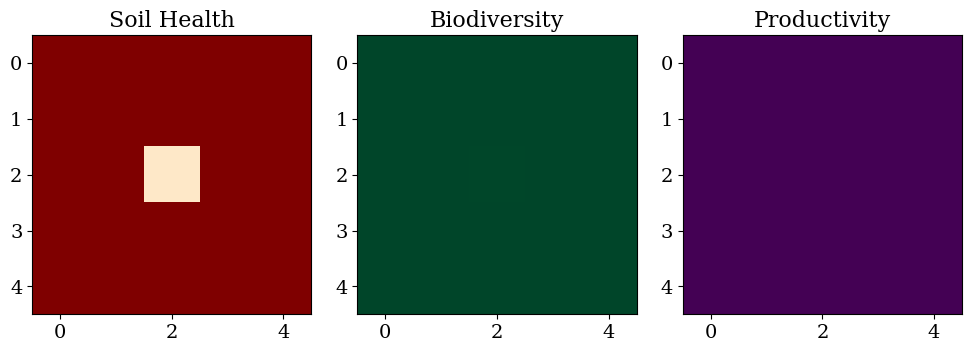

In [405]:
fig, axs = plt.subplots(1, 3, figsize=(10, 5))

axs[0].imshow(S[-1], cmap='OrRd', vmin = 0, vmax = 1)
axs[0].set_title('Soil Health')
axs[1].imshow(B[-1], cmap='YlGn', vmin = 0, vmax = 1)
axs[1].set_title('Biodiversity')
axs[2].imshow(np.where(~np.isnan(farms_ownership[-1]), farms_ownership[-1], 0), cmap='viridis', vmin = 0, vmax = farms_ownership[-1, ~np.isnan(farms_ownership[-1])].max())
axs[2].set_title('Productivity')

## Comparition with data

Text(0.5, 1.0, 'Land per Farmer')

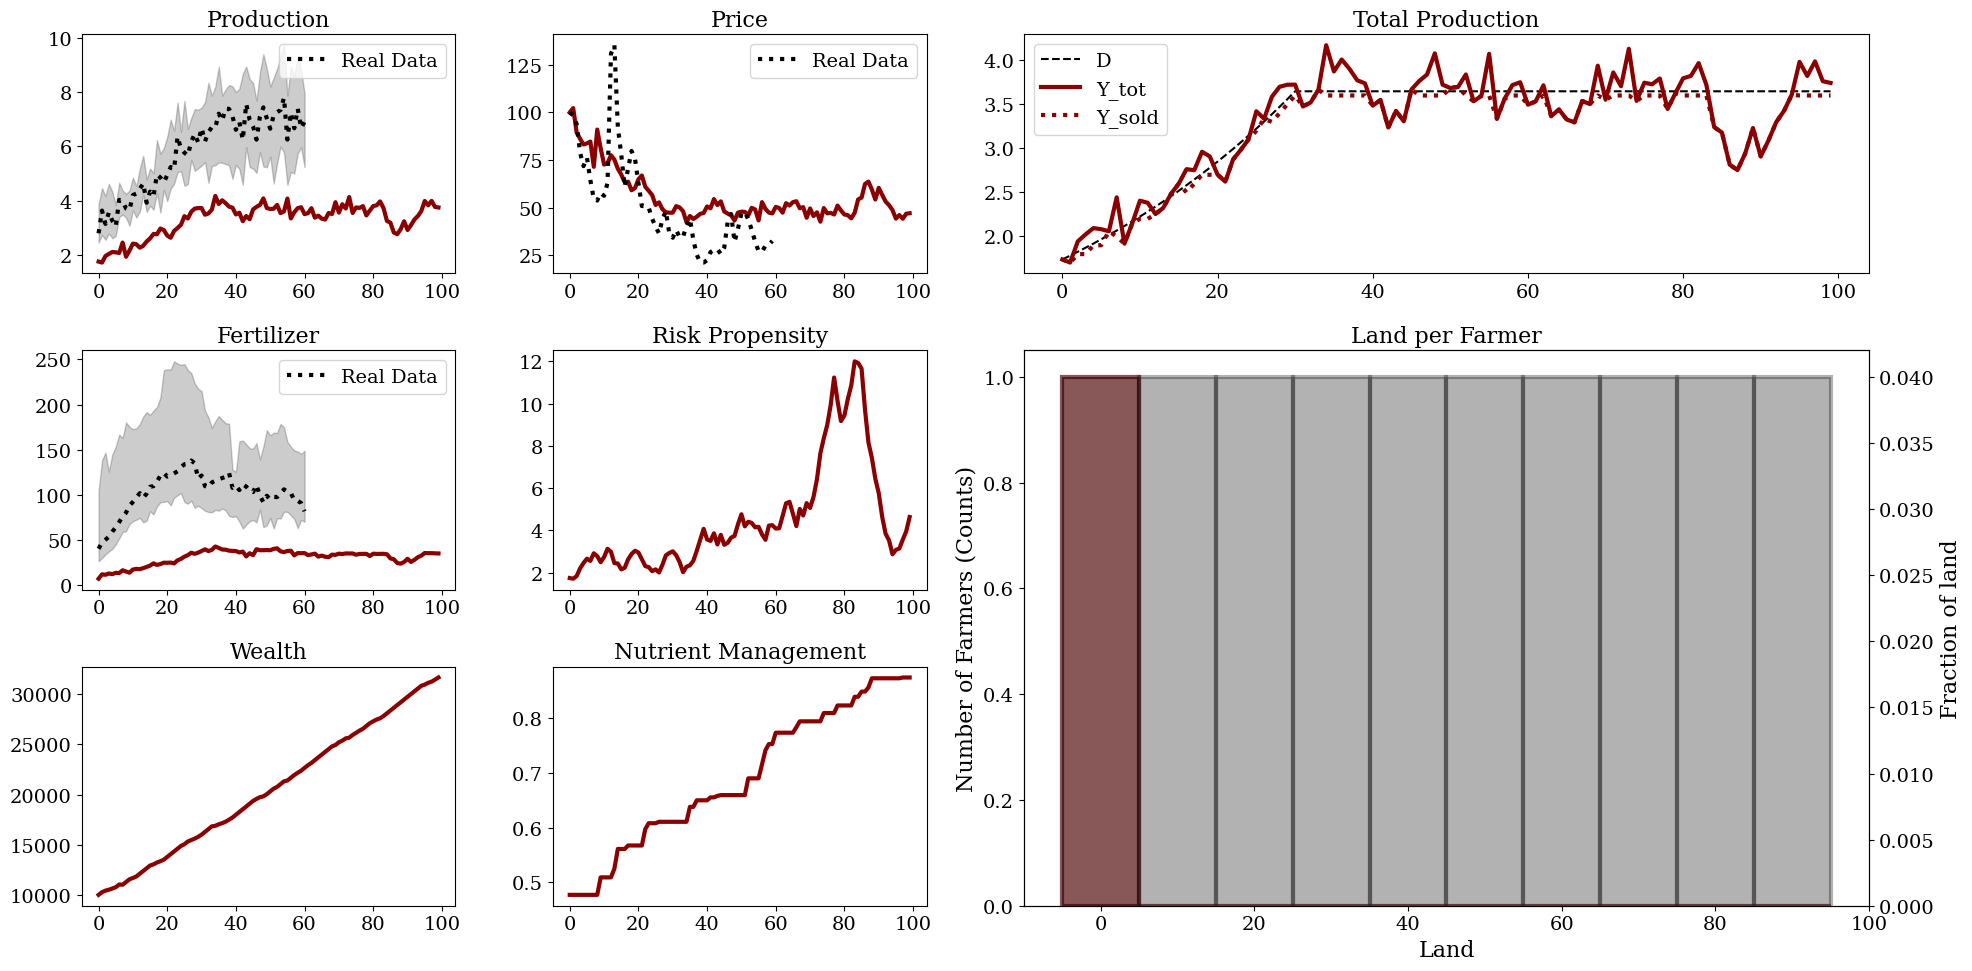

In [406]:
fig = plt.figure(figsize=(20,10))
gs = GridSpec(nrows=3, ncols=4)

c_matrix = generate_colormap_matrix('viridis', size)
color = 'darkred'

min_per = 25
max_per = 75

# Plotting demand and production
ax = fig.add_subplot(gs[0, 0])
per_50 = np.nanpercentile(np.where(active_farms == True, Y, np.nan), 50, axis=(1,2))
per_5 = np.nanpercentile(np.where(active_farms == True, Y, np.nan), min_per, axis=(1,2))
per_95 = np.nanpercentile(np.where(active_farms == True, Y, np.nan), max_per, axis=(1,2))
ax.plot(range(per_50.size), per_50, c=color, ls='-', lw = 3, zorder = 0.5)
ax.fill_between(range(per_50.size), per_5, per_95, color=color, alpha=0.2, zorder = 0.5)
df = df_list[1]
df = df[['Year', 'Area', 'Value']]
df_pivot = df.pivot('Year', 'Area', values='Value')
per_50 = np.nanpercentile(df_pivot, 50, axis=1)/10000
per_5 = np.nanpercentile(df_pivot, 5, axis=1)/10000
per_95 = np.nanpercentile(df_pivot, 95, axis=1)/10000
year = df_pivot.index.to_numpy()
ax.plot(range(per_50.size), per_50, c='k', ls=':', label='Real Data', lw = 3)
ax.fill_between(range(per_50.size), per_5, per_95, color='k', alpha=0.2)
ax.legend()
ax.set_title('Production')


# Plotting price and market price
ax = fig.add_subplot(gs[0, 1])
# for i in range(size):
#     ax.plot(range(np.sum(active_farms[:,i])), price[active_farms[:,i], i], linestyle='', marker = '.', c=c_matrix[i], lw = 3)
per_50 = np.nanpercentile(np.where(active_farms == True, price, np.nan), 50, axis=(1,2))
per_5 = np.nanpercentile(np.where(active_farms == True, price, np.nan), min_per, axis=(1,2))
per_95 = np.nanpercentile(np.where(active_farms == True, price, np.nan), max_per, axis=(1,2))
ax.plot(range(per_50.size), per_50/per_50[0]*100, c=color, lw = 3, zorder = 1)
ax.fill_between(range(per_50.size), per_5/per_50[0]*100, per_95/per_50[0]*100, color=color, alpha=0.2, zorder = 1)
# ax.plot(range(num_steps), market_price, linestyle='--', color='k', lw = 3, zorder = 2)
df = df_list[-1]
ax.plot(range(df['Year'].size), df['Value']/df['Value'].iloc[0]*100, c = 'k', ls = ':', lw = 3, label='Real Data')
ax.legend()
ax.set_title('Price')


# Plotting fertilizer
ax = fig.add_subplot(gs[1, 0])
# for i in range(size):
#     ax.plot(range(np.sum(active_farms[:,i])), F[active_farms[:,i], i], label='F', linestyle='-', c=color, lw = 0.5,zorder = 0)
per_50 = np.nanpercentile(np.where(active_farms == True, F, np.nan), 50, axis=(1,2))
per_5 = np.nanpercentile(np.where(active_farms == True, F, np.nan), min_per, axis=(1,2))
per_95 = np.nanpercentile(np.where(active_farms == True, F, np.nan), max_per, axis=(1,2))
ax.plot(range(per_50.size), per_50, c=color, lw = 3, zorder = 1)
ax.fill_between(range(per_50.size), per_5, per_95, color=color, alpha=0.2, zorder = 1)
df = df_list[2]
df = df[['Year', 'Area', 'Value']]
df_pivot = df.pivot('Year', 'Area', values='Value')
per_50 = np.nanpercentile(df_pivot, 50, axis=1)
per_5 = np.nanpercentile(df_pivot, 5, axis=1)
per_95 = np.nanpercentile(df_pivot, 95, axis=1)
year = df_pivot.index.to_numpy()
ax.plot(range(per_50.size), per_50, c='k', ls=':', label='Real Data', lw = 3, zorder = 2)
ax.fill_between(range(per_50.size), per_5, per_95, color='k', alpha=0.2, zorder = 2)
ax.legend()
ax.set_title('Fertilizer')

ax = fig.add_subplot(gs[1, 1])
# for i in range(size):
#     ax.plot(range(np.sum(active_farms[:,i])), Soil_health[active_farms[:,i], i], label='F', linestyle='-', c=c_matrix[i], lw = 3)
per_50 = np.nanpercentile(np.where(active_farms == True, inertia_rate, np.nan), 50, axis=(1,2))
per_5 = np.nanpercentile(np.where(active_farms == True, inertia_rate, np.nan), min_per, axis=(1,2))
per_95 = np.nanpercentile(np.where(active_farms == True, inertia_rate, np.nan), max_per, axis=(1,2))
ax.plot(range(per_50.size), per_50, c=color, lw = 3, zorder = 1)
ax.fill_between(range(per_50.size), per_5, per_95, color=color, alpha=0.2, zorder = 1)
ax.set_title('Risk Propensity')

# Plotting profit and wealth
ax = fig.add_subplot(gs[2, 0])
# for i in range(size):
#     ax.plot(range(np.sum(active_farms[:,i])), wealth[active_farms[:,i], i], linestyle='-', c=c_matrix[i], lw = 3)
per_50 = np.nanpercentile(np.where(active_farms == True, wealth, np.nan), 50, axis=(1,2))
per_5 = np.nanpercentile(np.where(active_farms == True, wealth, np.nan), min_per, axis=(1,2))
per_95 = np.nanpercentile(np.where(active_farms == True, wealth, np.nan), max_per, axis=(1,2))
ax.plot(range(per_50.size), per_50, c=color, lw = 3, zorder = 1)
ax.fill_between(range(per_50.size), per_5, per_95, color=color, alpha=0.2, zorder = 1)
ax.set_title('Wealth')

# Plotting profit and wealth
ax = fig.add_subplot(gs[2, 1])
# for i in range(size):
#     ax.plot(range(np.sum(active_farms[:,i])), MP[active_farms[:,i], i], linestyle='-', marker = '', c=c_matrix[i], lw = 3)
per_50 = np.nanpercentile(np.where(active_farms == True, MP, np.nan), 50, axis=(1,2))
per_5 = np.nanpercentile(np.where(active_farms == True, MP, np.nan), min_per, axis=(1,2))
per_95 = np.nanpercentile(np.where(active_farms == True, MP, np.nan), max_per, axis=(1,2))
ax.plot(range(per_50.size), per_50, c=color, lw = 3, zorder = 1)
ax.fill_between(range(per_50.size), per_5, per_95, color=color, alpha=0.2, zorder = 1)
ax.set_title('Nutrient Management')

ax = fig.add_subplot(gs[0, 2:])
ax.plot(range(num_steps), demand, linestyle='--', color='k', label ='D')
ax.plot(range(num_steps), np.sum(Y, axis=(1,2)), linestyle='-', c=color, lw = 3, label = 'Y_tot')
ax.plot(range(num_steps), np.sum(fraction_sold * Y, axis=(1,2)), linestyle=':', c=color, lw = 3, label='Y_sold')
ax.set_title('Total Production')
ax.legend()

ax = fig.add_subplot(gs[1:, 2:])
bins = np.arange(0, 101, 10)
hist, bin_edges = np.histogram(farms_ownership[-1], bins=bins)
cumulative_hist = np.cumsum(hist)
ax.bar(bin_edges[:-1], hist/np.sum(hist), width=10, facecolor='darkred', alpha=0.5, linewidth=3, edgecolor ='darkred')
ax.set_xlabel('Land')
ax.set_ylabel('Number of Farmers (Counts)')
ax.set_title('Land per Farmer')

# Create the second y-axis
ax2 = ax.twinx()
ax2.bar(bin_edges[:-1], cumulative_hist/size**2, width=10, facecolor='k', alpha=0.3, linewidth=3, edgecolor ='k')
ax2.set_ylabel('Fraction of land')
ax.set_title('Land per Farmer')